# Import datasets

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from mpl_toolkits import mplot3d
from collections import OrderedDict
%matplotlib inline

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
imdb_title_ratings = pd.read_csv('data/imdb.title.ratings.csv')
imdb_title_basics = pd.read_csv('data/imdb.title.basics.csv')
tn_movie_budgets = pd.read_csv('data/tn.movie_budgets.csv')

# Data Merge & Cleaning

In [3]:
imdb_joined = pd.merge(imdb_title_basics, imdb_title_ratings, on='tconst', how='left')

imdb_joined['title'] = imdb_joined['primary_title']

imdb_joined['year'] = imdb_joined['start_year']

tn_movie_budgets['title'] = tn_movie_budgets['movie']

tn_movie_budgets['year'] = tn_movie_budgets['release_date'].map(lambda x:x[-4:]).astype(int)

df = pd.merge(tn_movie_budgets, imdb_joined, on =["title", "year"], how ='left')

df['production_budget'] = df['production_budget'].map(lambda x:float(x.replace("$", "").replace(",", "")))
df['domestic_gross'] = df['domestic_gross'].map(lambda x:float(x.replace("$", "").replace(",", "")))
df['worldwide_gross'] = df['worldwide_gross'].map(lambda x:float(x.replace("$", "").replace(",", "")))

df['release_date'] = pd.to_datetime(df['release_date'])
df['release_year_month'] = df['release_date'].dt.to_period("M")

df = df.drop_duplicates(['title'])

df.drop(['id', 'movie', 'tconst', 'primary_title', 'original_title', 'start_year'], axis = 1, inplace = True)

df.isna().sum()

df = df[~df['runtime_minutes'].isna()]
df = df[~df['genres'].isna()]
df = df[~df['averagerating'].isna()]
df = df[~df['numvotes'].isna()]

df.isna().sum()

df.drop(df.index[df['domestic_gross'] == 0], inplace = True)
df.drop(df.index[df['worldwide_gross'] == 0], inplace = True)

df['domestic_profit'] = df['domestic_gross'] - df['production_budget']
df['worldwide_profit'] = df['worldwide_gross'] - df['production_budget']

df = df[['title', 'genres', 'runtime_minutes',\
        'year', 'release_year_month', 'release_date', 'averagerating',\
        'numvotes', 'production_budget', 'domestic_gross', 'domestic_profit',\
         'worldwide_gross', 'worldwide_profit']]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1294 entries, 1 to 5806
Data columns (total 13 columns):
title                 1294 non-null object
genres                1294 non-null object
runtime_minutes       1294 non-null float64
year                  1294 non-null int64
release_year_month    1294 non-null period[M]
release_date          1294 non-null datetime64[ns]
averagerating         1294 non-null float64
numvotes              1294 non-null float64
production_budget     1294 non-null float64
domestic_gross        1294 non-null float64
domestic_profit       1294 non-null float64
worldwide_gross       1294 non-null float64
worldwide_profit      1294 non-null float64
dtypes: datetime64[ns](1), float64(8), int64(1), object(2), period[M](1)
memory usage: 141.5+ KB


# Data Analysis

## 1. Profit: Domestic vs Worldwide

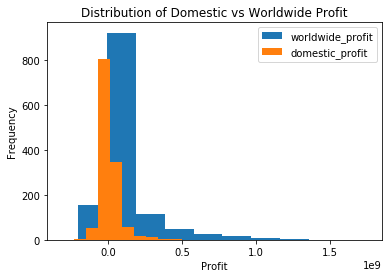

In [4]:
df['worldwide_profit'].plot(kind='hist') 
df['domestic_profit'].plot(kind='hist') 

plt.title('Distribution of Domestic vs Worldwide Profit')
plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.legend(loc='best')
plt.show()

## 2. Most widely produced genres in movie market

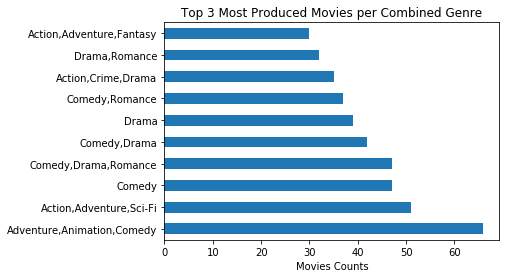

In [5]:
pd.value_counts(df['genres']).head(10).plot(kind='barh')   
plt.title('Top 3 Most Produced Movies per Combined Genre')
plt.xlabel('Movies Counts')
df['Percentage_Profit_Worldwide']=df['worldwide_profit']/df['production_budget']

## 3. Most profitable movies by genres 

Create subset for genres

In [9]:
genres_=list(((pd.value_counts(df['genres'])).to_dict()).keys())
counts_=list(((pd.value_counts(df['genres'])).to_dict()).values())
df1 = pd.DataFrame()
df1['genres_']=genres_
df1['counts_']=counts_
df1=df1.sort_values(by=['genres_'])
df_genre=(df.groupby(['genres']).mean())
# Adding the columns “counts” and “genres”
df_genre['counts'] = list(df1['counts_'])
df_genre['genres'] = list(df1['genres_'])

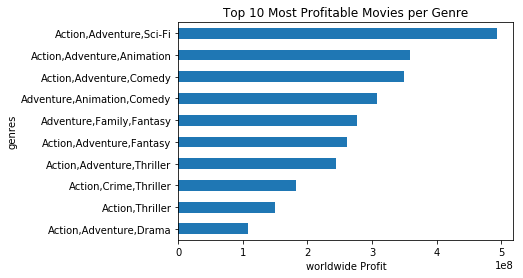

In [10]:
df_subset=pd.DataFrame()
df_subset['genres']=df_genre['genres']
df_subset['counts']=df_genre['counts']
df_subset['worldwide_profit']=df_genre['worldwide_profit']
df_subset['Perc']=df_genre['worldwide_profit']
df_subset['numvotes']=df_genre['numvotes']
df_subset['averagerating']=df_genre['averagerating']
df_subset['Percentage_Profit_Worldwide']=df_genre['Percentage_Profit_Worldwide']
df_subset= df_subset[(df_subset['counts']>=10)]


df_subset2 = df_subset.sort_values('worldwide_profit',ascending=True)
df_subset2['worldwide_profit'].tail(10).plot(kind='barh')
plt.xlabel('worldwide Profit')
plt.title('Top 10 Most Profitable Movies per Genre')
plt.show()

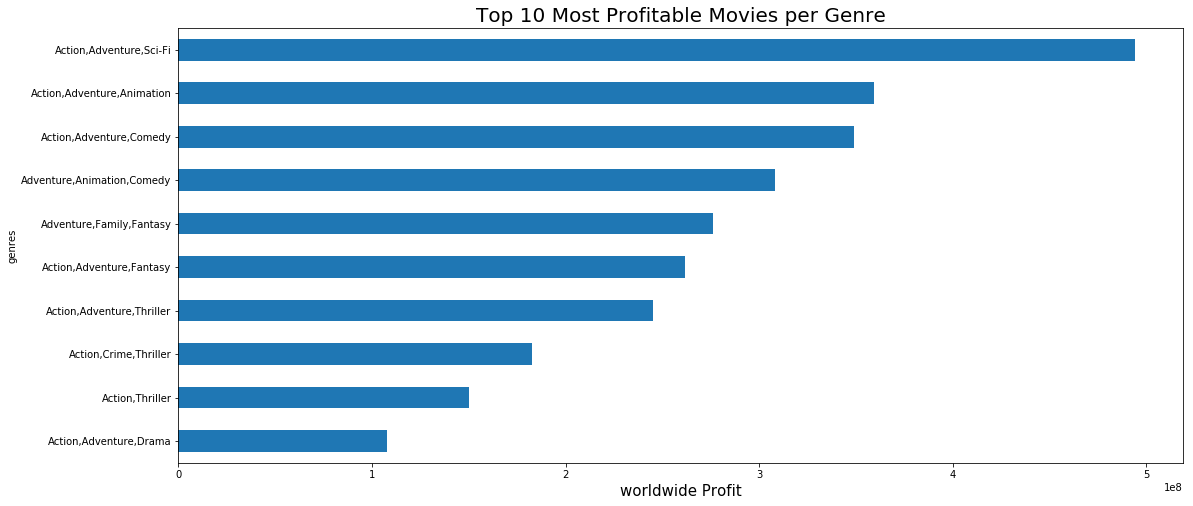

In [11]:
fig35 = plt.figure(figsize=(18, 8))
plt.plot()

df_subset2 = df_subset.sort_values('worldwide_profit',ascending=True)
df_subset2['worldwide_profit'].tail(10).plot(kind='barh')

plt.xlabel('worldwide Profit', fontsize=15)
plt.title('Top 10 Most Profitable Movies per Genre', fontsize=20)
plt.show()

fig35.savefig('profitable movies.png')

## 4. Movie counts by released month

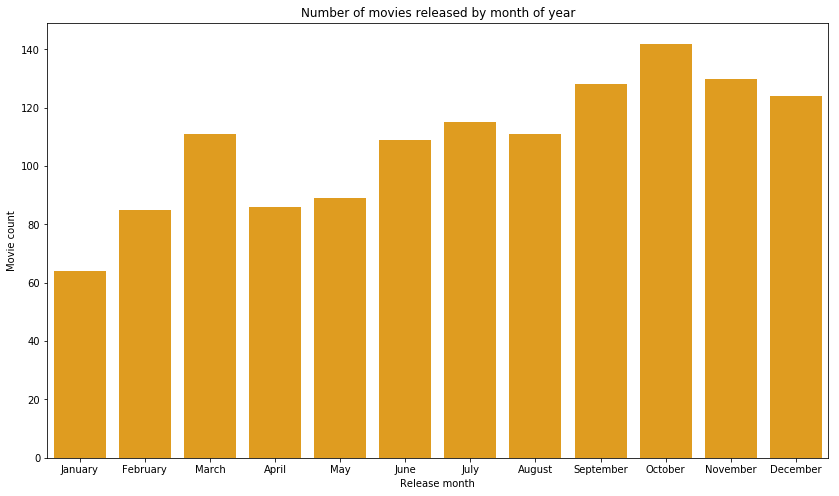

<Figure size 432x288 with 0 Axes>

In [12]:
df['release_month'] = df['release_date'].dt.month
df['release_month_str']=df.release_date.dt.strftime("%B")

fig31 = plt.figure(figsize=(14, 8))
plt.plot()

movie_by_month = df.groupby(['release_month','release_month_str']).title.count().reset_index()
sns.barplot('release_month_str','title', data= movie_by_month, color = 'orange')

plt.title('Number of movies released by month of year')
plt.xlabel('Release month')
plt.ylabel('Movie count')
plt.show()

fig31.savefig("movie count by release month.png")
plt.clf()

## 5. Profit by released month of year

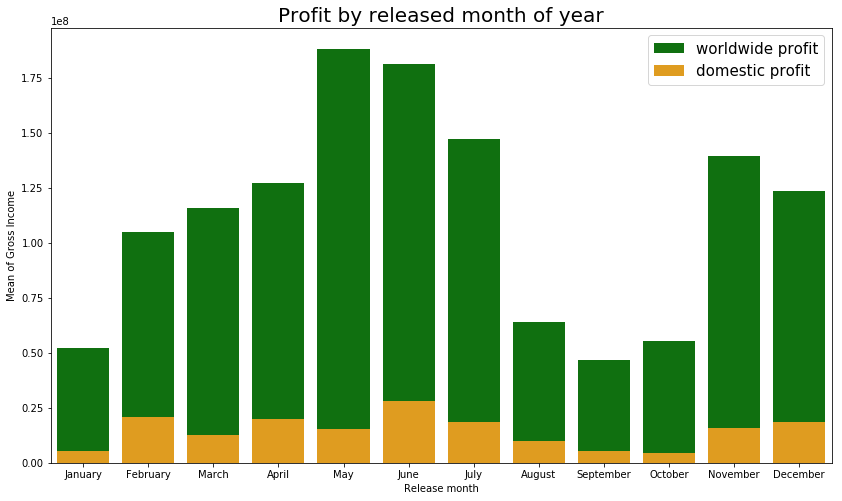

<Figure size 432x288 with 0 Axes>

In [13]:
fig32 = plt.figure(figsize=(14, 8))
plt.plot()

worldwide_profit_by_month = df.groupby(['release_month','release_month_str']).worldwide_profit.mean().reset_index()
sns.barplot('release_month_str','worldwide_profit', data= worldwide_profit_by_month, color = 'green', label="worldwide profit")
domestic_profit_by_month = df.groupby(['release_month','release_month_str']).domestic_profit.mean().reset_index()
sns.barplot('release_month_str','domestic_profit', data= domestic_profit_by_month, color = 'orange', label="domestic profit")

plt.title('Profit by released month of year', fontsize=20)
plt.xlabel('Release month')
plt.ylabel('Mean of Gross Income')
plt.legend(fontsize=15)
plt.show()

fig32.savefig("movie profit by release month.png")
plt.clf()